# Dimensionality reduction methods
The `torch_mist` package provides the dimensionality reduction methods based on information maximization and bottleneck with a simple interface. For this example we will consider the [California Housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing).


## Maximally Informative Dimensions

Using `TransformedMIEstimator` as a starting point, we can design a dimensionality reduction technique, which is known as "Maximally Informative Dimensions" (`MID`). The main idea being that we are interested in projecting some data `x` onto a lower dimensional space (either linearly or not) in such a way that we maximally preserve information about some other quantity `y`.

$$
\text{arg}\!\!\max_\theta I(f_\theta(x), y)
$$


In [1]:
from sklearn.datasets import fetch_california_housing

# Get the dataset as a pandas DataFrame
california_housing = fetch_california_housing(as_frame=True)
dataframe = california_housing['data']
features = list(dataframe.columns)
print(f"Features: {features}")
dataframe['Price'] = california_housing['target']

# We a 8D vector of all the features as X and the house price as Y
X = dataframe[features].values
Y = dataframe['Price'].values

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


The `MID` projection provides the same interface as classic `sklearn.decomposition` methods such as `PCA`, while still providing the flexibility to specify parameters for estimation and projection.

In [2]:
from torch_mist.decomposition import MID
from sklearn.decomposition import PCA

projections = {
    'PCA': PCA(2, whiten=True),
    'Non-Linear MID': MID(2, whiten=True),
    'Linear MID': MID(2, whiten=True, 
        proj_params={'hidden_dims': []}, # No hidden dimensions for the projection (Linear) 
        model_params={'estimator_name': 'infonce'}
    ),
}

The `fit(X, Y)` method takes care of training the projection and mutual information estimators. Additional training parameters can be also specified

In [3]:
from torch.optim import AdamW

print('Fitting PCA')
projections['PCA'].fit(X)

print('Fitting Non-Linear MID')
projections['Non-Linear MID'].fit(X, Y)

print('Fitting Linear MID')
projections['Linear MID'].fit(
    X, Y, 
    early_stopping=True, patience=2, 
    optimizer_class=AdamW,
)

Fitting PCA
Fitting Non-Linear MID
[Info]: batch_size is not specified, using batch_size=64 by default.
[Info]: max_epoch and max_iterations are not specified, using max_iterations=5000 by default.
[Info]: patience is not specified, using patience=1 (~2% of training epochs) by default.
Fitting Linear MID
[Info]: batch_size is not specified, using batch_size=64 by default.
[Info]: max_epoch and max_iterations are not specified, using max_iterations=5000 by default.


In [4]:
for name, proj in projections.items():
    z = proj.transform(X)
    dataframe[f'{name}[1]'] = z[:,0]
    dataframe[f'{name}[2]'] = z[:,1]

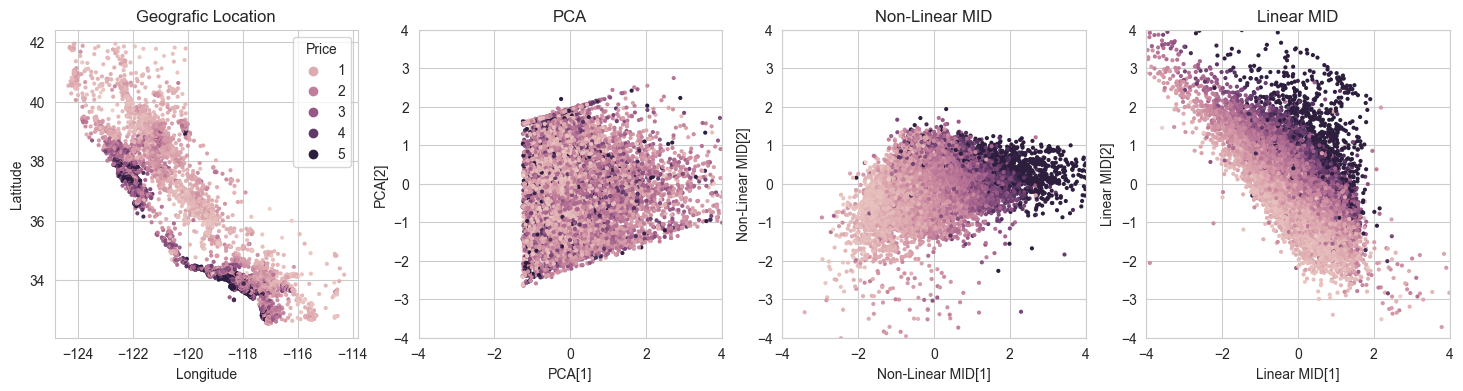

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(1,4, figsize=(18,4))

sns.scatterplot(dataframe, x='Longitude', y='Latitude', hue='Price', marker='.', ax=ax[0], linewidth=0)
ax[0].set_title("Geografic Location")

for i, name in enumerate(projections):
    sns.scatterplot(dataframe, x=f'{name}[1]', y=f'{name}[2]', hue='Price', marker='.', ax=ax[i+1], linewidth=0, legend=False)
    ax[i+1].set_title(name)
    ax[i+1].set_xlim(-4,4)
    ax[i+1].set_ylim(-4,4)


The training log is easily accessible with the `train_log` attribute after calling the `fit()` method

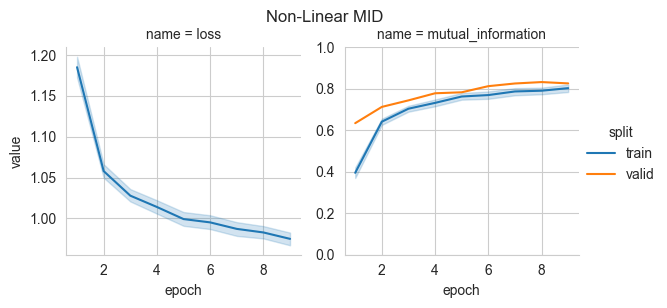

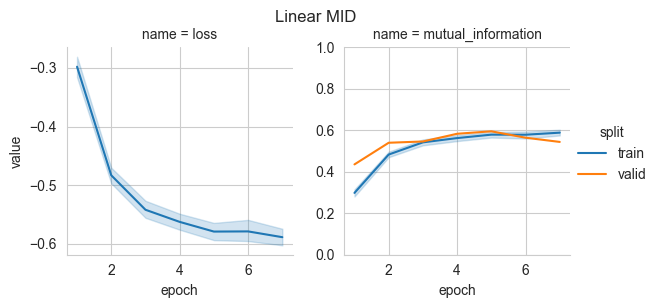

In [6]:
for name in ['Non-Linear MID', 'Linear MID']:
    grid = sns.FacetGrid(projections[name].train_log, col='name', hue='split', sharey=False)
    grid.map(sns.lineplot, 'epoch', 'value')
    grid.add_legend()
    grid.fig.suptitle(name, y=1.01);
    grid.axes[0,1].set_ylim(0,1)
    plt.show()

## Information Bottleneck 

Instead of solely focusing on information maximization, methods based on the information bottleneck principle also aim for minimal representations.
Herafter, we showcase the Variational Information Bottleneck (VIB), Cross-Entropy Bottleneck (CEB) and Multi-view Information Bottleneck (MIB) as dimensionality reduction methods that can be easily accessed and trained for relatively small datasets.
The Information Bottleneck training objective can be summarized as
$$
\text{arg}\max_\theta I(z;y) - \beta \underbrace{I(x;z)}_{\text{Regularizer}},
$$
in which $z$ is sampled from a stochastic encoder $p_\theta(z|x)$
The regularization strength $\beta$ balances between sufficiency (max $I(f_\theta(x);y)$) and minimality (min $I(f_\theta(x);x)$).


This is implemented differently in the three methods:

* VIB: The bottleneck is enforced through a prior $q_\phi(z)$ with $z=f_\theta(x)$:
$$
    \mathcal{R}_{VIB}(\theta;\phi) = KL(p_\theta(z|x)||q_\phi(z))
$$
* CEB: Use a conditional prior $q(z|y)$ instead of a marginal prior:
$$
    \mathcal{R}_{CEB}(\theta;\phi) = KL(p_\theta(z|x)||q_\phi(z|y))
$$
* MIB: Use two encoders $p_\theta(z|x)$ and $q_\phi(z|y)$ as a symmetrized version of CEB
$$
    \mathcal{R}_{MIB}(\theta;\phi) = \frac{1}{2}KL(p_\theta(z|x)||q_\phi(z|y)) + \frac{1}{2}KL(q_\phi(z|y)|p_\theta(z|x))
$$

In [7]:
from torch_mist.decomposition import VIB, CEB, MIB

ib_projections = {}
ib_projections['VIB (beta=0.001)'] = VIB(2, beta=0.001, stochastic_transform=True)
ib_projections['VIB (beta=0.1)'] = VIB(2, beta=0.1, stochastic_transform=True)
ib_projections['CEB'] = CEB(2, whiten=True)
ib_projections['MIB'] = MIB(2, whiten=True)

The parameter `stochastic_transform` refers to how the data $x$ is transformed using the `.transform(x)` method. When stochastic transform is set to `True`, $z$ is a sample from $p_\theta(z|x)$, otherwise $z$ is obtained deterministically by considering the mean of the corresponding normal distribution.

In [8]:
for name in ib_projections:
    print(f'Fitting {name}')
    ib_projections[name].fit(X, Y, max_epochs=10, early_stopping=False, batch_size=128)

Fitting VIB (beta=0.001)
Fitting VIB (beta=0.1)
Fitting CEB
Fitting MIB


In [9]:
for name, proj in ib_projections.items():
    z = proj.transform(X)
    dataframe[f'{name}[1]'] = z[:,0]
    dataframe[f'{name}[2]'] = z[:,1]

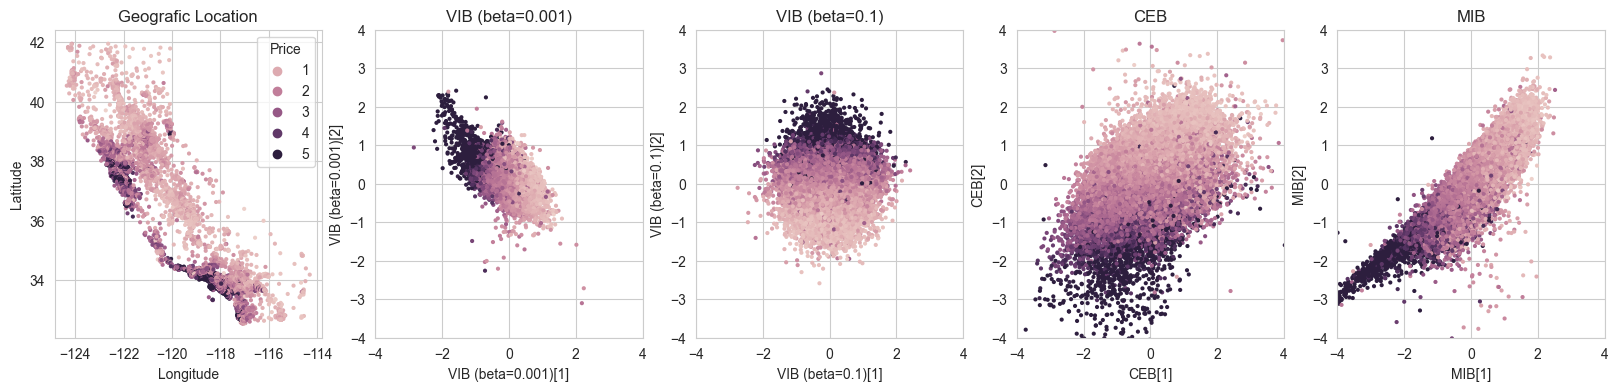

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(1,len(ib_projections)+1, figsize=(20,4))

sns.scatterplot(dataframe, x='Longitude', y='Latitude', hue='Price', marker='.', ax=ax[0], linewidth=0)
ax[0].set_title("Geografic Location")

for i, name in enumerate(ib_projections):
    sns.scatterplot(dataframe, x=f'{name}[1]', y=f'{name}[2]', hue='Price', marker='.', ax=ax[i+1], linewidth=0, legend=False)
    ax[i+1].set_title(name)
    ax[i+1].set_xlim(-4,4)
    ax[i+1].set_ylim(-4,4)


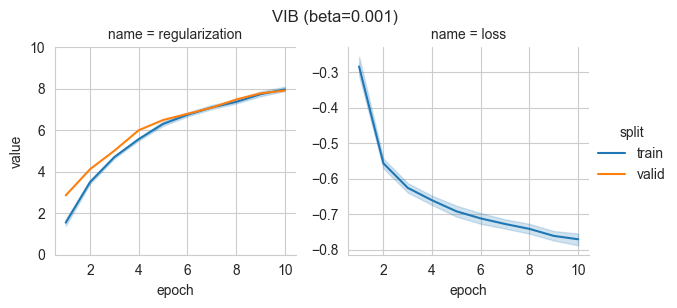

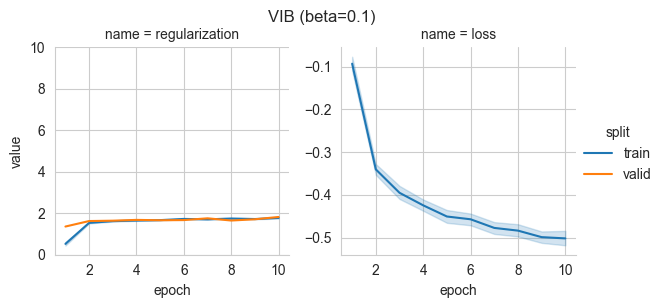

In [11]:
for name in ['VIB (beta=0.001)', 'VIB (beta=0.1)']:
    grid = sns.FacetGrid(ib_projections[name].train_log, col='name', hue='split', sharey=False)
    grid.map(sns.lineplot, 'epoch', 'value')
    grid.add_legend()
    grid.fig.suptitle(name, y=1.01);
    grid.axes[0,0].set_ylim(0,10)
    plt.show()